# Investigate training data

The training data are a bit messy, we can't really be sure which badges were used as the numbering sheme doesn't seem to match up.

This notebook tries to answer the burning question of _which badges do we care about?_

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry.polygon import LinearRing
from scipy.misc import imread
import json
import pickle
import math

import helpers

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

Get the data out of the pickle. This is pickled by the `load candidate data from csv` notebook.

This is what we're dealing with:

In [2]:
c_data = pd.read_pickle("candidate_data.p")
c_data.head()

,minor,time,rssi,agentId
0,288,2016-11-23 23:06:34.012,-72,000000007d418b7a
1,288,2016-11-23 23:06:34.019,-82,00000000029d74c5
2,360,2016-11-23 23:06:34.059,-96,00000000c7ce4c76
3,360,2016-11-23 23:06:34.061,-75,000000005e6ed248
4,360,2016-11-23 23:06:34.061,-87,00000000fc7843f8


If we just have a look at what we've got here:

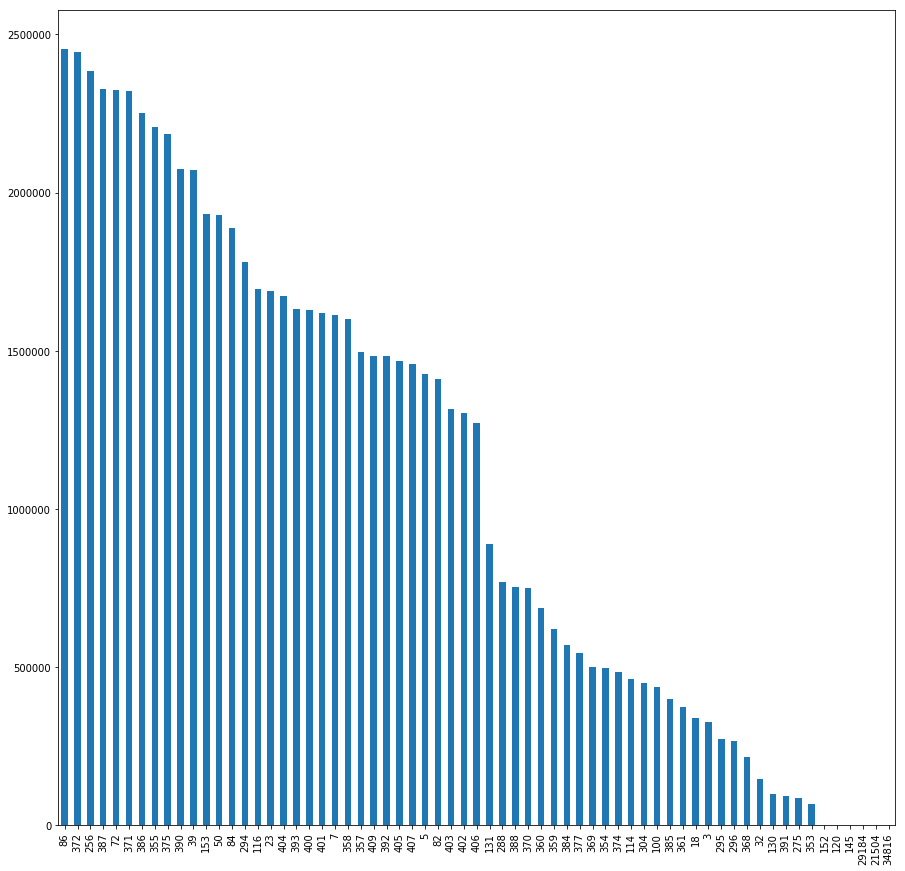

In [3]:
c_data.minor.value_counts().plot(kind="bar")

I don't really understand this, seems odd that some badges would be recorded more than others. If the badges broadcast once a seconds then I'd imagine that 

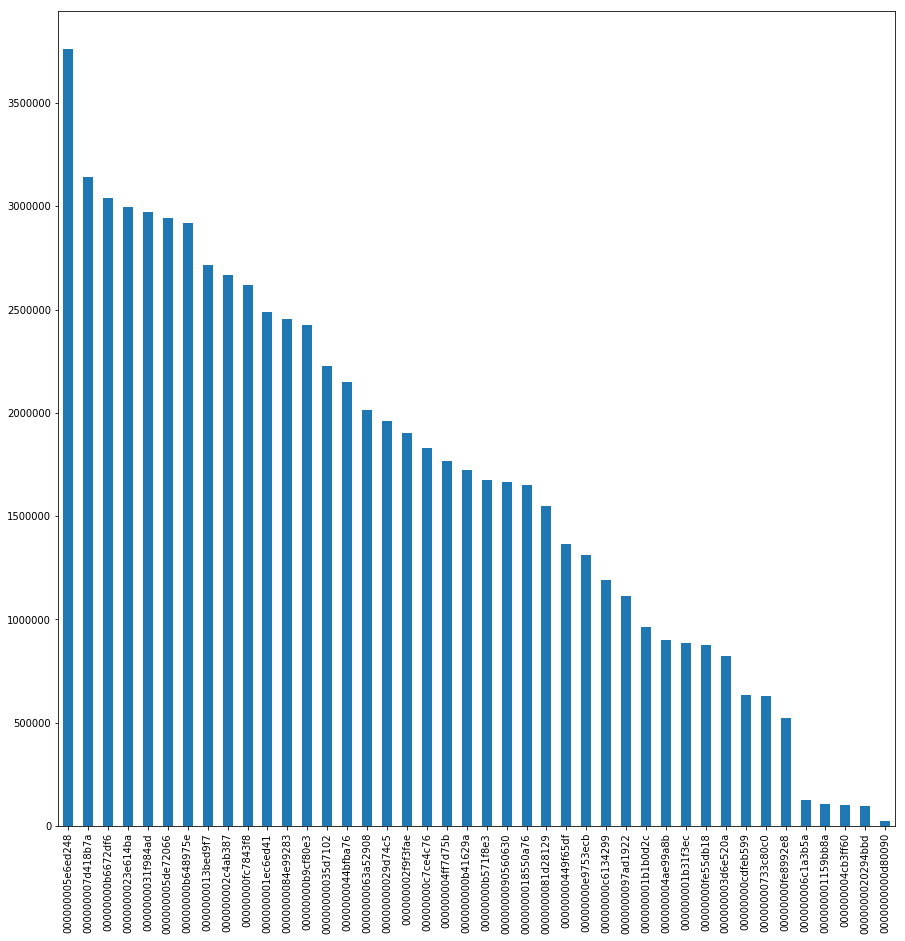

In [4]:
c_data.agentId.value_counts().plot(kind="bar")

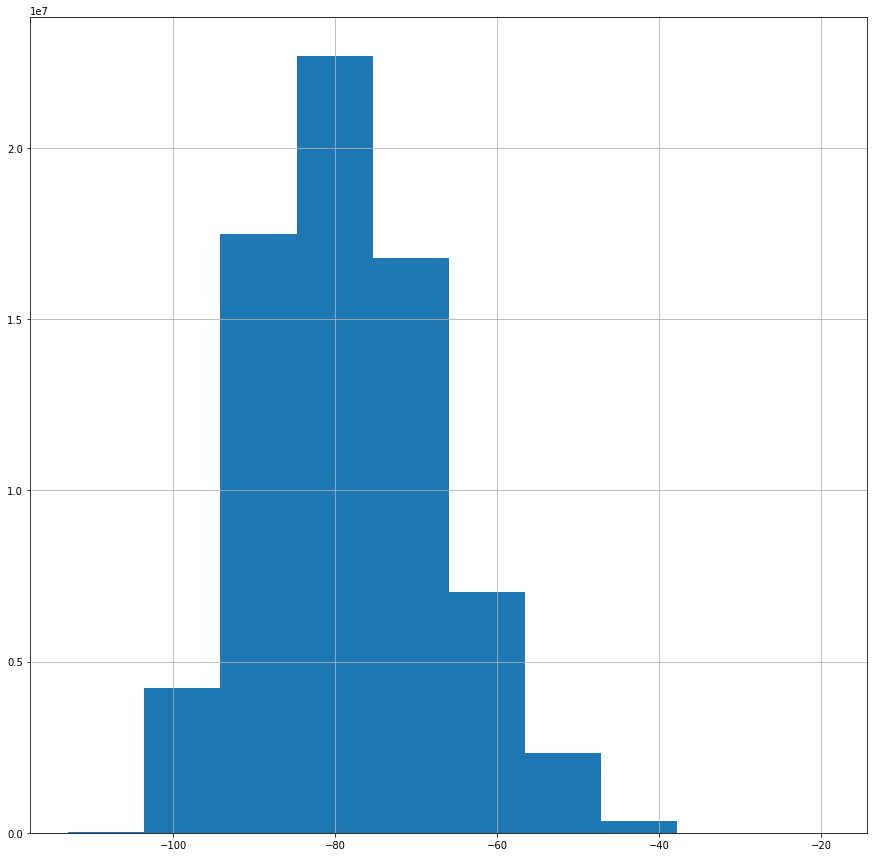

In [5]:
c_data.rssi.hist()

In [8]:
d = pickle.load( open( "infrastructure_store.p", "rb" ) )    

stickerLocations = pd.DataFrame.from_dict(d["stickerLocations"])
baseStationData  = pd.DataFrame.from_dict(d['baseStationData'])
seats            = pd.DataFrame.from_dict(d['seats'])
outer   = d['outer']
inner   = d['inner']
isovist = d['isovist']

# print ("stickerLocations")
# print (stickerLocations.head(2))
# print ("\n\nbaseStationData")
# print (baseStationData.head(2))
# print ("\n\nouter")
# print (outer[0])
# print ("\n\ninner")
# print (inner[0])
# print ("\n\nseats")
# print (seats.head(2))
# print ("\n\nisovist")
# print (isovist[0])
    
OG = nx.read_gpickle("graph.p")
# if graph.p can't be found, run BVN infrastructure and layout first

In [11]:
def draw_infrastructure(title="Sticker and Base Station Locations", draw_graph=False, draw_img=False, 
                        draw_boundaries=False, draw_axes=False, draw_stickers=False, draw_basestations=False, draw_seat_names=False,
                        pad_x_pc=0.05, pad_y_pc=0.01,
                       sticker_label_size=7, name_label_size=5, base_label_size=10):
    """Draw the fixed infrastructure of the sensicorn project."""
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    
    def plot_line(ob, colour="r"):
        x, y = ob.xy
        plt.plot(x, y, color=colour, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    
    fig, ax = plt.subplots()

    plt.title(title)
    
    legend_items = []
    
    # set axis limits with a bit of padding
    x = [pair[0] for pair in outer[0]] # get boundary limits
    y = [pair[1] for pair in outer[0]]
    pad_y = (max(y) - min(y)) * pad_y_pc
    pad_x = (max(x) - min(x)) * pad_x_pc
    axes = plt.gca()
    axes.set_ylim([min(y) - pad_y, max(y) + pad_y])
    axes.set_xlim([min(x) - pad_x, max(x) + pad_x])
    
    if draw_img:
        # put the image on the graph as an underlay
        img = imread("map.png")
        ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
        #                                [left, right, bottom, top  ]

    if draw_boundaries:
        for boundary_set, colour in [(inner, "r"),(isovist, "g"),(outer, "b")]:
            for e in boundary_set:
                ring = LinearRing(e)
                plot_line(ring, colour)
        legend_inner = mlines.Line2D([], [], color='r', label='Inner Boundary')
        legend_isovist = mlines.Line2D([], [], color='g', label='Isovist Boundary')
        legend_outer = mlines.Line2D([], [], color='b', label='Outer Boundary')
        legend_items.extend([legend_inner, legend_isovist, legend_outer])

    if draw_graph:
        pos = {n[0]: (n[1]["x"], n[1]["y"]) for n in OG.nodes(data=True)}
        nx.draw(OG, alpha=0.3, s=1, pos=pos, node_shape=".", node_size=10)  # don't draw the graph

    if draw_basestations:
        # put the baseStations on the map
        for index, row in baseStationData.iterrows():
            if not math.isnan(row.x) and not math.isnan(row.y):
                ax.text(row.x, row.y, row.agentName, fontsize=base_label_size)
            else:
                print(row.x, row.y, row.agentName, "not shown because probably not used.")
        base_stations = ax.scatter(baseStationData.x, baseStationData.y, marker='+', label='base stations')
        legend_items.append(base_stations)

    if not draw_axes:
        # Hide the axis numbers because they don't tell us much
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if draw_stickers:
        # the sticker labels
        for _, row in stickerLocations.iterrows():
            ax.text(row.x, row.y, "{0:03d}".format(int(row.stickerID)), fontsize=sticker_label_size)

        # sticker dots
        stickers = ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y", label='stickers')
        legend_items.append(stickers)
    
    if draw_seat_names:
        for _, row in seats.iterrows():
            ax.text(row.x, row.y, row["name"], fontsize=name_label_size, rotation=10) # .name must be a reserved word?

        # sticker dots
        seat_pos = ax.scatter(seats.x, seats.y, s=1, c="y", label='seats')
        legend_items.append(seat_pos)
        
    
    if len(legend_items) > 0:
        # red_patch = mpatches.Patch(color='red', label='The red data') # patch example
        plt.legend(handles=legend_items, loc='upper left')

    plt.show()

Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\

nan nan X-ray not shown because probably not used.
nan nan X-men not shown because probably not used.
nan nan Yankee not shown because probably not used.
nan nan Yorker not shown because probably not used.
nan nan Zebra not shown because probably not used.
nan nan Zulu not shown because probably not used.


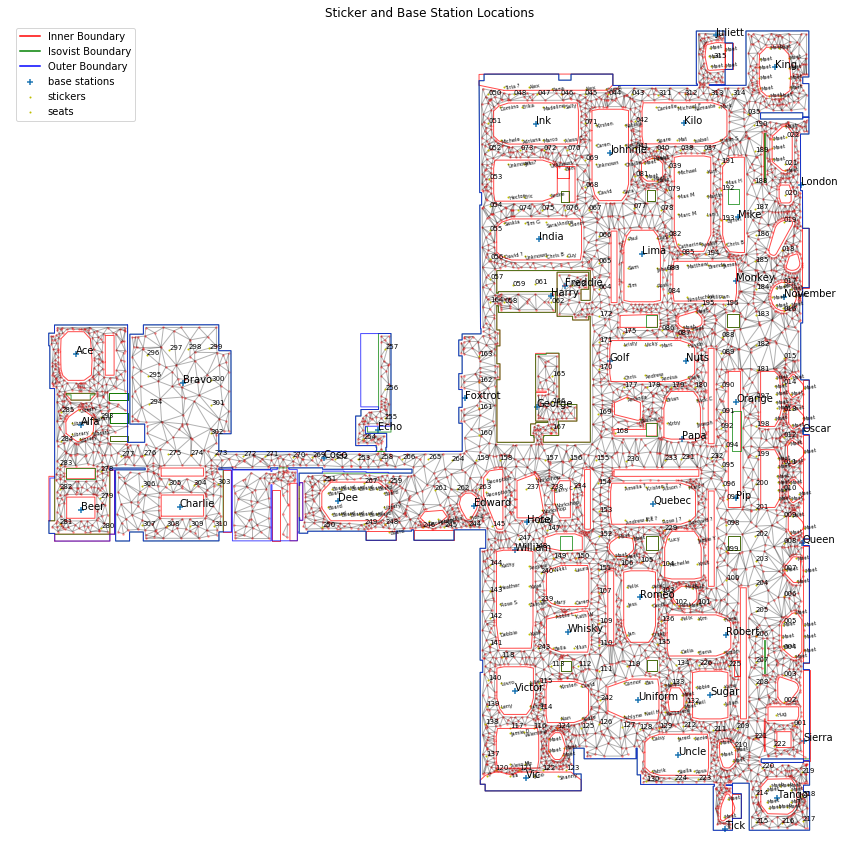

In [14]:
draw_infrastructure(draw_boundaries=True, 
                    draw_stickers=True, 
                    draw_basestations=True, 
                    draw_seat_names=True,
                    draw_graph=True)